In [1]:
import json;
import pandas as pd;
import scipy;
from scipy import stats;
# from apyori import apriori;
import matplotlib.pyplot as plt;
import numpy as np;
import sklearn
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import tree
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [2]:
data_path = 'okcupid_11_25_22.csv'
df = pd.read_csv(data_path)

# drop columns you're not using, convert sex to bool
df.loc[ df['sex'] == 'f', 'sex'] = 0
df.loc[ df['sex'] == 'm', 'sex'] = 1
df = df.filter(items = ['age', 'body_type', 'drinks', 'height', 'smokes', 'education', 'orientation', 'sex'])
# drop rows with too many blank values
df = df[df.isnull().sum(axis=1) < 3]

In [3]:
df.fillna('rather not say', inplace=True)
# drop rows with no height
df = df[df['height'] != 'rather not say']
df = df[df['body_type'] != 'rather not say']

attraction_dict = {'attractive': ['athletic', 'curvy', 'fit','full figured', 'jacked', 'thin'],
                   'unattractive': ['overweight', 'skinny', 'used up', 'a little extra', 'average']}
education_dict = {'some_college': ['dropped out of college/university', 'dropped out of two-year college', 'graduated from two-year college', 
                                   'two-year college', 'working on college/university', 'working on two-year college'],
                  'some_high_school': ['dropped out of high school', 'working on high school'], 
                  'post_secondary': ['graduated from law school', 'graduated from masters program', 'graduated from med school',
                                       'graduated from ph.d program', 'law school', 'masters program', 'med school', 'ph.d program'],
                  'college': ['college/university', 'dropped out of masters program', 'dropped out of med school', 'dropped out of ph.d program',
                              'graduated from college/university', 'dropped out of law school', 'working on law school', 'working on masters program',
                              'working on med school', 'working on ph.d program'],
                  'high_school': ['graduated from high school', 'high school'],
                  'space_camp': ['graduated from space camp', 'dropped out of space camp', 'space camp', 'working on space camp']}
frequency_dict = {'a_lot': ['desperately', 'often', 'very often', 'trying to quit', 'yes'],
                  'never': ['not at all', 'no' ],
                  'sometimes': ['rarely', 'socially', 'sometimes', 'when drinking']}
answer_bank = ['athletic', 'curvy', 'fit','full figured', 'jacked', 'a little extra', 'average', 'thin', 'overweight', 'skinny', 'used up',
               'dropped out of college/university', 'dropped out of two-year college', 'graduated from two-year college', 
               'two-year college', 'working on college/university', 'dropped out of law school', 'working on two-year college', 'dropped out of high school', 'working on high school', 
               'dropped out of high school', 'working on high school', 'graduated from law school', 'graduated from masters program', 'graduated from med school',
               'graduated from ph.d program', 'law school', 'masters program', 'med school', 'ph.d program','college/university', 'dropped out of masters program', 'dropped out of med school', 'dropped out of ph.d program',
               'graduated from college/university', 'graduated from high school', 'high school', 'desperately', 'often', 'very often', 'trying to quit', 'yes', 'not at all', 'no', 'rarely', 'socially', 'sometimes', 'when drinking', 
               'working on ph.d program', 'working on law school', 'working on masters program', 'working on med school']

In [4]:
dict_list = [attraction_dict, frequency_dict, education_dict]
columns_list = ['body_type', 'drinks', 'smokes', 'education']

for c in columns_list:
     for entry in df[c]:
        if 'space camp' in entry:
            df.loc[ df[c] == entry, c] = 'space camp'
        else:
             for d in dict_list:
                for key in d:
                    if entry in d[key]:
                        if entry in answer_bank:
                            df.loc[ df[c] == entry, c] = key
                            answer_bank.remove(entry)
df

age     body_type     drinks height     smokes       education  \
0       22  unattractive  sometimes   75.0  sometimes    some_college   
1       35  unattractive      a_lot   70.0      never      space camp   
2       38    attractive  sometimes   68.0      never  post_secondary   
3       23    attractive  sometimes   71.0      never    some_college   
4       29    attractive  sometimes   66.0      never         college   
...    ...           ...        ...    ...        ...             ...   
59933   32    attractive  sometimes   69.0      never         college   
59938   24    attractive      a_lot   72.0      never    some_college   
59939   42  unattractive      never   71.0      never  post_secondary   
59940   27    attractive  sometimes   73.0      a_lot    some_college   
59941   39  unattractive  sometimes   68.0  sometimes  post_secondary   

      orientation  sex  
0        straight    1  
1        straight    1  
2        straight    1  
3        straight    1  
4        straight    1  
...           ...  ...  
59933    bisexual    1  
59938    straight    1  
59939    straight    1  
59940    straight    1  
59941         gay    1  

[53746 rows x 8 columns]

In [5]:
from sklearn import preprocessing
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
df['body_type']= label_encoder.fit_transform(df['body_type'])
df['body_type'].unique()
df

age  body_type     drinks height     smokes       education  \
0       22          1  sometimes   75.0  sometimes    some_college   
1       35          1      a_lot   70.0      never      space camp   
2       38          0  sometimes   68.0      never  post_secondary   
3       23          0  sometimes   71.0      never    some_college   
4       29          0  sometimes   66.0      never         college   
...    ...        ...        ...    ...        ...             ...   
59933   32          0  sometimes   69.0      never         college   
59938   24          0      a_lot   72.0      never    some_college   
59939   42          1      never   71.0      never  post_secondary   
59940   27          0  sometimes   73.0      a_lot    some_college   
59941   39          1  sometimes   68.0  sometimes  post_secondary   

      orientation  sex  
0        straight    1  
1        straight    1  
2        straight    1  
3        straight    1  
4        straight    1  
...           ...  ...  
59933    bisexual    1  
59938    straight    1  
59939    straight    1  
59940    straight    1  
59941         gay    1  

[53746 rows x 8 columns]

{22: 988, 35: 1023, 29: 1915, 31: 1583, 28: 2025, 30: 1828, 26: 2110, 27: 2147, 38: 829, 20: 473, 32: 1494, 43: 498, 37: 867, 24: 1755, 34: 1113, 46: 328, 36: 964, 21: 629, 39: 704, 50: 263, 48: 289, 51: 205, 33: 1293, 25: 1934, 59: 113, 41: 593, 23: 1376, 19: 268, 40: 628, 53: 134, 45: 387, 47: 337, 49: 279, 42: 655, 55: 152, 63: 65, 61: 93, 66: 51, 44: 413, 57: 134, 52: 203, 64: 52, 18: 143, 56: 147, 60: 100, 65: 55, 69: 15, 62: 89, 54: 153, 67: 38, 58: 104, 68: 23}
{22: 710, 35: 549, 38: 406, 23: 911, 29: 1046, 32: 783, 31: 852, 37: 436, 28: 1113, 30: 969, 39: 367, 33: 687, 26: 1176, 27: 1133, 20: 381, 25: 1167, 40: 307, 36: 483, 21: 524, 34: 574, 43: 290, 24: 1093, 46: 206, 41: 303, 42: 320, 45: 213, 55: 90, 50: 131, 59: 99, 48: 163, 54: 95, 51: 122, 62: 64, 44: 230, 52: 109, 19: 257, 58: 74, 66: 49, 53: 91, 63: 62, 47: 159, 49: 153, 61: 76, 60: 81, 57: 101, 18: 131, 56: 106, 64: 52, 65: 47, 69: 15, 68: 27, 67: 25}


Text(0.5, 0.98, 'Age vs Unattractive | Age vs Attractive | a=attractive, u=unattractive, f=female, m=male')

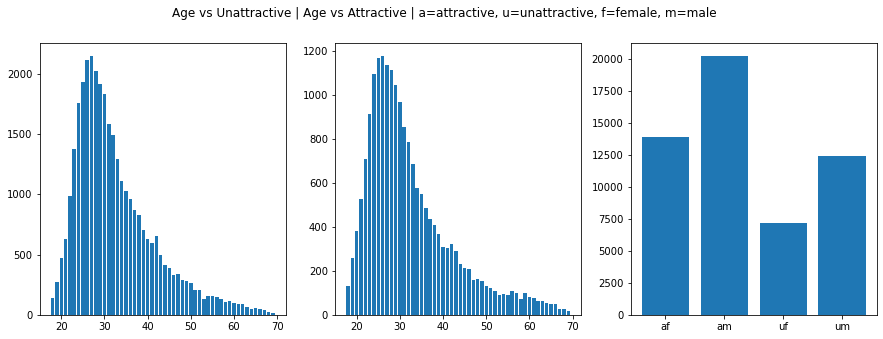

In [47]:
male_female_attractiveness = { 'attractive_female': len(np.where((df['body_type'] == 0) & (df['sex'] == 0))[0]), 
 'attractive_male': len(np.where((df['body_type'] == 0) & (df['sex'] == 1))[0]), 
 'unattractive_female': len(np.where((df['body_type'] == 1) & (df['sex'] == 0))[0]), 
 'unattractive_male': len(np.where((df['body_type'] == 1) & (df['sex'] == 1))[0]) }

attractive_age = {}
un_attractive_age = {}

for i in range(df.shape[0]):
    entry = df.iloc[i]
    age = entry['age']
    if entry['body_type'] == 0:
        if age not in un_attractive_age:
            un_attractive_age[age] = 0
        if age in attractive_age:
            attractive_age[age] += 1
        else:
            attractive[age] = 1
    else:
        if age not in attractive_age:
            attractive_age[age] = 0
        if age in un_attractive_age:
            un_attractive_age[age] += 1
        else:
            un_attractive_age[age] = 1
            
print(attractive_age)
print(un_attractive_age)



names_aa = list(attractive_age.keys())
values_aa = list(attractive_age.values())

names_au = list(un_attractive_age.keys())
values_au = list(un_attractive_age.values())

names_mfa = ['af', 'am', 'uf', 'um']
values_mfa = list(male_female_attractiveness.values())

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].bar(names_aa, values_aa)
axs[1].bar(names_au, values_au)
axs[2].bar(names_mfa, values_mfa)
fig.suptitle('Age vs Unattractive | Age vs Attractive | a=attractive, u=unattractive, f=female, m=male')

In [33]:
def attractive_hist_dict(df, column):
    attractive = {}
    un_attractive = {}
    for i in range(df.shape[0]):
        entry = df.iloc[i]
        c = entry[column]
        if entry['body_type'] == 0:
            if c not in un_attractive:
                un_attractive[c] = 0
            if c in attractive:
                attractive[c] += 1
            else:
                attractive[c] = 1
        else:
            if c not in attractive:
                attractive[c] = 0
            if c in un_attractive:
                un_attractive[c] += 1
            else:
                un_attractive[c] = 1
    return attractive, un_attractive


cols = ['age', 'drinks', 'height', 'smokes', 'education', 'orientation', 'sex']
attr_arr = []
unattr_arr = []
for col in cols:
    dict_tuple = attractive_hist_dict(df, col)
    attr_arr.append(dict_tuple[0])
    unattr_arr.append(dict_tuple[1])


        

{22: 0.5818610129564193, 35: 0.6507633587786259, 38: 0.6715210355987055, 23: 0.6023570493234396, 29: 0.6468602295746118, 32: 0.656578947368421, 31: 0.6501026694045174, 37: 0.6656441717791411, 28: 0.6453154875717018, 30: 0.653557382910261, 39: 0.6582867783985102, 33: 0.6544265593561368, 26: 0.6421180766889836, 27: 0.6545731707317073, 20: 0.5538641686182669, 25: 0.6240335051546392, 40: 0.6727078891257996, 36: 0.6664364640883977, 21: 0.5467128027681661, 34: 0.6601539372409709, 43: 0.631979695431472, 24: 0.6162219101123596, 46: 0.6142322097378277, 41: 0.6625835189309577, 42: 0.673469387755102, 45: 0.6467661691542289, 55: 0.6296296296296297, 50: 0.6683544303797468, 59: 0.5352112676056338, 48: 0.6393805309734514, 54: 0.62, 51: 0.6269113149847095, 62: 0.5897435897435898, 44: 0.6434108527131783, 52: 0.653968253968254, 19: 0.5114068441064639, 58: 0.6042780748663101, 66: 0.5148514851485149, 53: 0.5973451327433629, 63: 0.515625, 47: 0.6794354838709677, 49: 0.6458333333333334, 61: 0.55029585798816

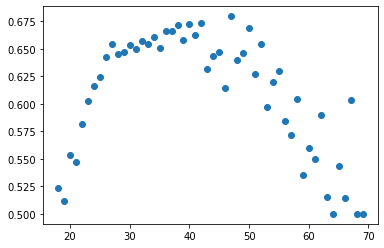

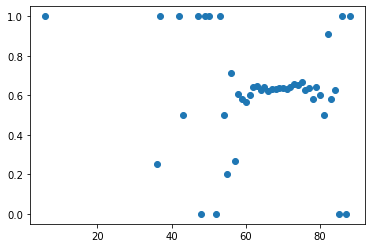

In [38]:
#print(attr_arr[1])
#print(unattr_arr[1])
ratio_arr = []
for i in range(len(attr_arr)):
    ratio_dict = {}
    for key in attr_arr[i]:
        attr_p = attr_arr[i][key]/(attr_arr[i][key] + unattr_arr[i][key])
        ratio_dict[key] = attr_p
    ratio_arr.append(ratio_dict)
    
    print(ratio_dict)
    print('\n')
        
x = sorted(ratio_arr[0].keys())
y = []

for num in x:
    y.append(ratio_arr[0][num])
    
fig1 = plt.figure(1)
plt.scatter(x, y)
print(f"Linear Correlations Age:")
print(f"    Pearson Correlation: {stats.pearsonr(x, y)}")
print(f"    Spearman Correlation: {stats.spearmanr(x, y)}")


x2 = sorted(ratio_arr[2].keys())
y2 = []

for num in x2:
    y2.append(ratio_arr[2][num])
    
fig1 = plt.figure(2)
plt.scatter(x2, y2)
print(f"Linear Correlations Height:")
print(f"    Pearson Correlation: {stats.pearsonr(x2, y2)}")
print(f"    Spearman Correlation: {stats.spearmanr(x2, y2)}")

plt.show()

In [48]:
df = pd.get_dummies(data=df, columns=['drinks', 'smokes', 'education', 'orientation'])
df.columns

Index(['age', 'body_type', 'height', 'sex', 'drinks_a_lot', 'drinks_never',
       'drinks_rather not say', 'drinks_sometimes', 'smokes_a_lot',
       'smokes_never', 'smokes_rather not say', 'smokes_sometimes',
       'education_college', 'education_high_school',
       'education_post_secondary', 'education_rather not say',
       'education_some_college', 'education_some_high_school',
       'education_space camp', 'orientation_bisexual', 'orientation_gay',
       'orientation_straight'],
      dtype='object')

In [49]:
# drop rows with no height
#df = df[df['height'] != 'rather not say']
X = df.filter(items = ['age', 'smokes', 'education', 'orientation']).values
y = df['body_type'].values
y=y.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=14)
df

age  body_type height  sex  drinks_a_lot  drinks_never  \
0       22          1   75.0    1             0             0   
1       35          1   70.0    1             1             0   
2       38          0   68.0    1             0             0   
3       23          0   71.0    1             0             0   
4       29          0   66.0    1             0             0   
...    ...        ...    ...  ...           ...           ...   
59933   32          0   69.0    1             0             0   
59938   24          0   72.0    1             1             0   
59939   42          1   71.0    1             0             1   
59940   27          0   73.0    1             0             0   
59941   39          1   68.0    1             0             0   

       drinks_rather not say  drinks_sometimes  smokes_a_lot  smokes_never  \
0                          0                 1             0             0   
1                          0                 0             0             1   
2                          0                 1             0             1   
3                          0                 1             0             1   
4                          0                 1             0             1   
...                      ...               ...           ...           ...   
59933                      0                 1             0             1   
59938                      0                 0             0             1   
59939                      0                 0             0             1   
59940                      0                 1             1             0   
59941                      0                 1             0             0   

       ...  education_college  education_high_school  \
0      ...                  0                      0   
1      ...                  0                      0   
2      ...                  0                      0   
3      ...                  0                      0   
4      ...                  1                      0   
...    ...                ...                    ...   
59933  ...                  1                      0   
59938  ...                  0                      0   
59939  ...                  0                      0   
59940  ...                  0                      0   
59941  ...                  0                      0   

       education_post_secondary  education_rather not say  \
0                             0                         0   
1                             0                         0   
2                             1                         0   
3                             0                         0   
4                             0                         0   
...                         ...                       ...   
59933                         0                         0   
59938                         0                         0   
59939                         1                         0   
59940                         0                         0   
59941                         1                         0   

       education_some_college  education_some_high_school  \
0                           1                           0   
1                           0                           0   
2                           0                           0   
3                           1                           0   
4                           0                           0   
...                       ...                         ...   
59933                       0                           0   
59938                       1                           0   
59939                       0                           0   
59940                       1                           0   
59941                       0                           0   

       education_space camp  orientation_bisexual  orientation_gay  \
0                         0                     0                0   
1         

In [50]:
decision_tree_best = tree.DecisionTreeClassifier() 
decision_tree_best.fit(X_train, y_train)
y_preds = decision_tree_best.predict(X_test)

scoresVC_p = precision_score(y_test, y_preds, average=None)
scoresVC_r = recall_score(y_test, y_preds, average=None) 

print("Decision Tree Precision: ", scoresVC_p)
print("Recall: ", scoresVC_r)

Decision Tree Precision:  [0.63348837 0.        ]
Recall:  [1. 0.]


C:\Users\13369\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
lr_best = LogisticRegression() 
lr_best.fit(X_train, y_train)
y_preds = lr_best.predict(X_test)

scoresVC_p_lr = precision_score(y_test, y_preds, average=None)
scoresVC_r_lr = recall_score(y_test, y_preds, average=None) 

print("Logistic Regression Precision: ", scoresVC_p_lr)
print("Recall: ", scoresVC_r_lr)

Logistic Regression Precision:  [0.63348837 0.        ]
Recall:  [1. 0.]


C:\Users\13369\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
knn_best = KNeighborsClassifier() 
knn_best.fit(X_train, y_train)
y_preds = knn_best.predict(X_test)

scoresVC_p_knn = precision_score(y_test, y_preds, average=None)
scoresVC_r_knn = recall_score(y_test, y_preds, average=None) 

print("KNN Precision: ", scoresVC_p_knn)
print("Recall: ", scoresVC_r_knn)

KNN Precision:  [0.63904762 0.37438202]
Recall:  [0.59118943 0.42284264]


In [53]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
knn_pipe = Pipeline([('mms', MinMaxScaler()),
                     ('knn', KNeighborsClassifier())])
params = [{'knn__n_neighbors': [200, 300, 400],
         'knn__weights': ['uniform', 'distance'],
         'knn__leaf_size': [1, 3, 7, 9, 11, 13, 15, 20]}]
gs_knn = GridSearchCV(knn_pipe,
                      param_grid=params,
                      scoring='accuracy',
                      cv=5)
gs_knn.fit(X_train, y_train)
print(gs_knn.best_params_)

{'knn__leaf_size': 1, 'knn__n_neighbors': 400, 'knn__weights': 'uniform'}


In [54]:
y_preds_gscv = gs_knn.predict(X_test)
scoresVC_p_knn = precision_score(y_test, y_preds_gscv, average=None)
scoresVC_r_knn = recall_score(y_test, y_preds_gscv, average=None) 
print("KNN Precision: ", scoresVC_p_knn)
print("Recall: ", scoresVC_r_knn)

KNN Precision:  [0.63362069 0.38461538]
Recall:  [0.99295154 0.00761421]


In [55]:
params_dt = [{'criterion': ['gini', 'entropy'], 'max_depth': [1, 7, 15, None], 'splitter': ['best', 'random'],
           'min_samples_leaf': [1, 4, 7, 10], 'min_samples_split': [3, 7, 11, 16]}]
gs_dt = GridSearchCV(tree.DecisionTreeClassifier(),
                      param_grid=params_dt,
                      scoring='accuracy',
                      cv=5)
gs_dt.fit(X_train, y_train)

print(gs_dt.best_params_)
y_preds_gscv_dt = gs_dt.predict(X_test)
scoresVC_p_dt = precision_score(y_test, y_preds_gscv_dt, average=None)
scoresVC_r_dt = recall_score(y_test, y_preds_gscv_dt, average=None) 
print("Decision Tree GSCV Precision: ", scoresVC_p_dt)
print("Recall: ", scoresVC_r_dt)

{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'best'}
Decision Tree GSCV Precision:  [0.63348837 0.        ]
Recall:  [1. 0.]


C:\Users\13369\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
one = 0 
two = 0
zero = 0
class_appearances = [zero, one, two]
for e in y_test: 
    class_appearances[e] += 1
print(class_appearances)

[3405, 1970, 0]


In [15]:
#KNN Precision:  [0.54811412 0.4503632  0.        ]
#Recall:  [0.78334485 0.24833111 0.        ]
#KNN Precision:  [0.55060241 0.45142857 0.        ]
#Recall:  [0.78956462 0.24610592 0.        ]
#KNN Precision:  [0.54511199 0.46153846 0.        ]
#Recall:  [0.89979267 0.12283044 0.        ]
#KNN Precision:  [0.54628317 0.49315068 0.        ]
#Recall:  [0.93192813 0.09612817 0.        ]

'''
{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 7, 'splitter': 'random'}
Decision Tree GSCV Precision:  [0.54630004 0.48951049 0.        ]
Recall:  [0.93365584 0.09345794 0.        ]


'''

"\n{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 7, 'splitter': 'random'}\nDecision Tree GSCV Precision:  [0.54630004 0.48951049 0.        ]\nRecall:  [0.93365584 0.09345794 0.        ]\n\n\n"

In [57]:
from sklearn.ensemble import VotingClassifier
est_vec = [('a', decision_tree_best), ('b', lr_best), ('c', knn_best), ('d', gs_knn), ('e', gs_dt)]
eclf = VotingClassifier(estimators=est_vec)
eclf.fit(X_train, y_train)
y_preds_eclf = eclf.predict(X_test)
scoresVC_p_eclf = precision_score(y_test, y_preds_eclf, average=None)
scoresVC_r_eclf = recall_score(y_test, y_preds_eclf, average=None) 
print("Voting GSCV Precision: ", scoresVC_p_eclf)
print("Recall: ", scoresVC_r_eclf)

Voting GSCV Precision:  [0.63348837 0.        ]
Recall:  [1. 0.]


C:\Users\13369\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
bc = BaggingClassifier(base_estimator=gs_dt, n_estimators=100)
bc.fit(X_train, y_train)

BaggingClassifier(base_estimator=GridSearchCV(cv=5,
                                              estimator=DecisionTreeClassifier(),
                                              param_grid=[{'criterion': ['gini',
                                                                         'entropy'],
                                                           'max_depth': [1, 7,
                                                                         15,
                                                                         None],
                                                           'min_samples_leaf': [1,
                                                                                4,
                                                                                7,
                                                                                10],
                                                           'min_samples_split': [3,
                                              

In [59]:
y_preds_bm = bc.predict(X_test)
scores_bc_p = precision_score(y_test, y_preds_bm, average=None)
scores_bc_r = recall_score(y_test, y_preds_bm, average=None) 
print("Bagging GSCV Precision: ", scores_bc_p)
print("Recall: ", scores_bc_r)

Bagging GSCV Precision:  [0.63348837 0.        ]
Recall:  [1. 0.]


C:\Users\13369\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:
print("F1 Scores: ", (2*scores_bc_p*scores_bc_r)/(scores_bc_r+scores_bc_p))

F1 Scores:  [0.77562642        nan]


C:\Users\13369\AppData\Local\Temp\ipykernel_10544\567624145.py:1: RuntimeWarning: invalid value encountered in true_divide
  print("F1 Scores: ", (2*scores_bc_p*scores_bc_r)/(scores_bc_r+scores_bc_p))
